# OSMnx overview: querying, simplifying, visualizing, saving

Author: [Geoff Boeing](https://geoffboeing.com/)

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Documentation](https://osmnx.readthedocs.io/en/stable/)
  - [Journal article/citation](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  
Once you've perused the [features demo notebook](00-osmnx-features-demo.ipynb), this notebook demonstrates more details on querying for place boundaries and street networks, visualizing, and saving models to disk.

In [2]:
import geopandas as gpd
import osmnx as ox

%matplotlib inline
ox.__version__

'1.6.0'

You can configure OSMnx using the `settings` module. See the [documentation](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.settings) for the settings you can configure. For example, by default OSMnx caches all server responses to prevent repeatedly hitting the server for the same query every time you run it. This both makes our code faster on subsequent runs and helps us be a "good neighbor" to the server. But you can turn caching off (or back on again) with the `use_cache` setting.

In [2]:
# turn response caching off
ox.settings.use_cache = False

# turn it back on and turn on/off logging to your console
ox.settings.use_cache = True
ox.settings.log_console = False

## Part 1: get place boundaries from OpenStreetMap

OSMnx lets you download place boundary geometries from OpenStreetMap, project them, and plot them. For a more in-depth demonstration of querying by place, see [this notebook](03-graph-place-queries.ipynb).

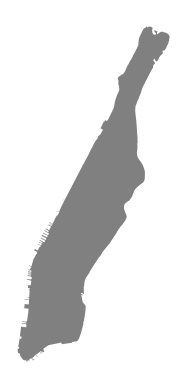

In [3]:
# get the boundary polygon for manhattan, project it, and plot it
city = ox.geocode_to_gdf("Manhattan, New York, USA")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")

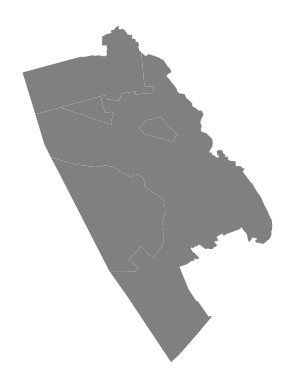

In [4]:
# get boundary polygons for several cities, save as GeoPackage, project to UTM, and plot
place_names = [
    "Berkeley, California, USA",
    "Oakland, California, USA",
    "Piedmont, California, USA",
    "Emeryville, California, USA",
    "Alameda, Alameda County, CA, USA",
]
east_bay = ox.geocode_to_gdf(place_names)
east_bay.to_file("./data/east_bay.gpkg", driver="GPKG")
east_bay = ox.project_gdf(east_bay)
ax = east_bay.plot(fc="gray", ec="none")
_ = ax.axis("off")

In [5]:
# if you know the OSM ID of the place(s) you want, you can query it directly
ox.geocode_to_gdf(["R357794", "N8170768521", "W427818536"], by_osmid=True)

geometry  bbox_north  bbox_south  \
0  POLYGON ((135.55901 35.13689, 135.55907 35.136...   35.321221   34.874916   
1                          POINT (13.38882 52.51699)   52.521988   52.511988   
2  POLYGON ((-73.98141 40.76846, -73.98135 40.768...   40.800314   40.764745   

    bbox_east   bbox_west   place_id  osm_type      osm_id        lat  \
0  135.878442  135.559006  263065557  relation      357794  35.021041   
1   13.393820   13.383820  159407166      node  8170768521  52.516988   
2  -73.949606  -73.981408   15524776       way   427818536  40.782773   

          lon     class            type  place_rank  importance addresstype  \
0  135.755607  boundary  administrative          14    0.653138        city   
1   13.388820   railway         station          30    0.000010     railway   
2  -73.965363   leisure            park          24    0.565172        park   

               name                                       display_name  
0             Kyoto                     Kyoto, Kyoto Prefecture, Japan  
1  Unter den Linden  Unter den Linden, Friedrichstraße, Dorotheenst...  
2      Central Park  New York County, New York, United States, Cent...

## Part 2: download and model street networks

OSMnx lets you download street network data and build topologically-corrected street networks, project and plot the networks, and save the street network as SVGs, GraphML files, or GeoPackages for later use. The street networks are directed and preserve one-way directionality. For a more in-depth demonstration of creating street networks, see [this notebook](03-graph-place-queries.ipynb).

You can download a street network by providing OSMnx any of the following (demonstrated in the examples below):
  - a bounding box
  - a lat-long point plus a distance
  - an address plus a distance
  - a place name or list of place names (to automatically geocode and get the boundary of)
  - a polygon of the desired street network's boundaries
  - a .osm formatted xml file

You can also specify several different network types:
  - 'drive' - get drivable public streets (but not service roads)
  - 'drive_service' - get drivable streets, including service roads
  - 'walk' - get all streets and paths that pedestrians can use (this network type ignores one-way directionality)
  - 'bike' - get all streets and paths that cyclists can use
  - 'all' - download all non-private OSM streets and paths (this is the default network type unless you specify a different one)
  - 'all_private' - download all OSM streets and paths, including private-access ones

 #### Method #1, pass a bounding box ####
 This constructs the network from all the OSM nodes and ways within the bounding box.

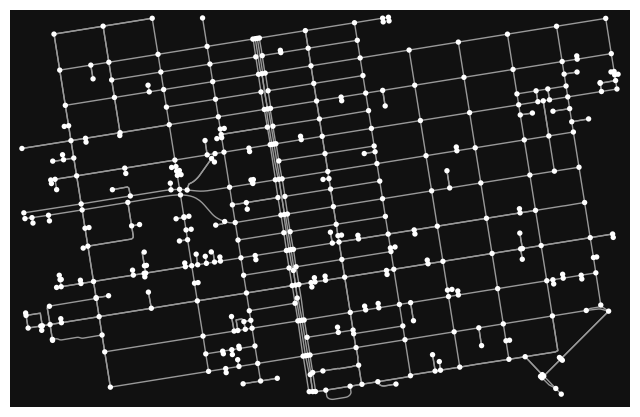

In [7]:
# define a bounding box in San Francisco
north, south, east, west = 37.79, 37.78, -122.41, -122.43

# create network from that bounding box
G = ox.graph_from_bbox(north, south, east, west, network_type="drive_service")
fig, ax = ox.plot_graph(G)

#### Method #2, pass a lat-lng point and bounding box distance in meters
This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box.

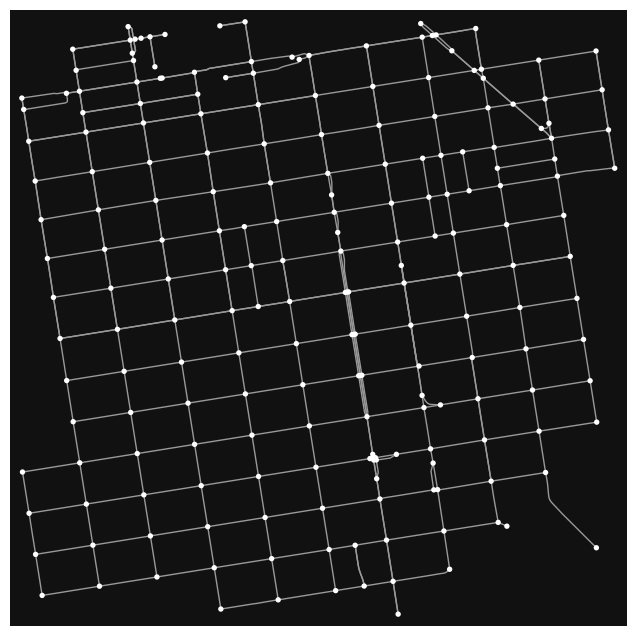

In [8]:
# define a point at the corner of California St and Mason St in SF
location_point = (37.791427, -122.410018)

# create network from point, inside bounding box of N, S, E, W each 750m from point
G = ox.graph_from_point(location_point, dist=750, dist_type="bbox", network_type="drive")
fig, ax = ox.plot_graph(G)

#### Method #3, pass a lat-lng point and *network* distance in meters ####

This creates a bounding box *n* meters North, South, East, and West of the point, then constructs the network from all the OSM nodes and ways within the bounding box. Then it truncates the network by removing all nodes further than *n* meters from the point along the network.

In [ ]:
# same point again, but create network only of nodes within 500m along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network")
fig, ax = ox.plot_graph(G, node_color="r")

*Note* the plot above shows the network within 500m (traveling distance along the network) from the `location_point`. By default, the `network_type` parameter value is 'all', meaning that we do not filter out paths that restrict certain types of traffic. This also means that one-way streets are honored as one-way and you cannot travel the wrong direction down them. Thus, the 500m takes into account only those nodes you can reach within 500m while only traveling in the allowed direction of the street. Instead (below), we can specify `network_type='walk'` to build a street network only of paths that walking is allowed on. This also makes every path bi-directional in the directed network, because you can walk in either direction on the sidewalk of a one-way street. Thus, the 500m now takes into account those nodes you can reach within 500m while traveling in either direction (even if it's a one-way street).

In [ ]:
# create network only of nodes within 500m walking along the network from point
G = ox.graph_from_point(location_point, dist=500, dist_type="network", network_type="walk")
fig, ax = ox.plot_graph(G, node_color="r")

#### Method #4, pass an address and distance (*bounding box* or *network*) in meters ####
This geocodes the address, creates a bounding box, downloads the network, then truncates it by network distance (if distance_type='network').

In [ ]:
# network from address, including only nodes within 1km along the network from the address
G = ox.graph_from_address(
    address="350 5th Ave, New York, NY",
    dist=1000,
    dist_type="network",
    network_type="drive",
)

# you can project the network to UTM (zone calculated automatically)
G_projected = ox.project_graph(G)

#### Method #5, pass a place name ####

This geocodes the place name, gets the place's boundary shape polygon and bounding box, downloads the network within the bounding box, then truncates it to the place's boundary polygon.

In [ ]:
# create the street network within the city of Piedmont's borders
G = ox.graph_from_place("Piedmont, California, USA", network_type="drive")

In [ ]:
# you can also pass multiple places as a mixed list of strings and/or dicts
places = [
    "Los Altos, California, USA",
    {"city": "Los Altos Hills", "state": "California"},
    "Loyola, California",
]
G = ox.graph_from_place(places, truncate_by_edge=True)

In [ ]:
# save to disk as GeoPackage file then plot
ox.save_graph_geopackage(G)
fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

#### Method #6, pass a polygon ####

This example loads the [Mission District](http://www.zillow.com/howto/api/neighborhood-boundaries.htm)'s polygon from a ShapeFile, then downloads the network within its bounding box, then prunes all nodes that lie outside the place's boundary polygon.

In [ ]:
calif = gpd.read_file("input_data/ZillowNeighborhoods-CA")
mission_district = calif[(calif["CITY"] == "San Francisco") & (calif["NAME"] == "Mission")]
polygon = mission_district["geometry"].iloc[0]

G2 = ox.graph_from_polygon(polygon, network_type="drive_service")

#### Method #7, load a .osm xml file

In [ ]:
# create graph from .osm extract file
G = ox.graph_from_xml("./input_data/West-Oakland.osm.bz2")

## Part 3: simplifying street network topology

Simplification is normally done by OSMnx automatically under the hood, but we can break it out to see how it works. OpenStreetMap nodes are weird. They include intersections, but they also include all the points along a single block where the street curves. The latter are not nodes in the graph theory sense, so we remove them algorithmically and consolidate the set of edges between "true" network nodes into a single edge. There are two simplification modes, strict and non-strict. The main difference is that unlike strict mode, non-strict mode allows simplification to an "expansion graph" (ie, if the graph were undirected, nodes with degree 2 as long as the incident edges have different OSM IDs). For a more in-depth demonstration of topological simplification with OSMnx, see [this notebook](04-simplify-graph-consolidate-nodes.ipynb).

In [19]:
# create a network around some (lat, lng) point but do not simplify it yet
location_point = (33.2995218, -111.8243060)
G = ox.graph_from_point(location_point, network_type="all", dist=500, simplify=False)

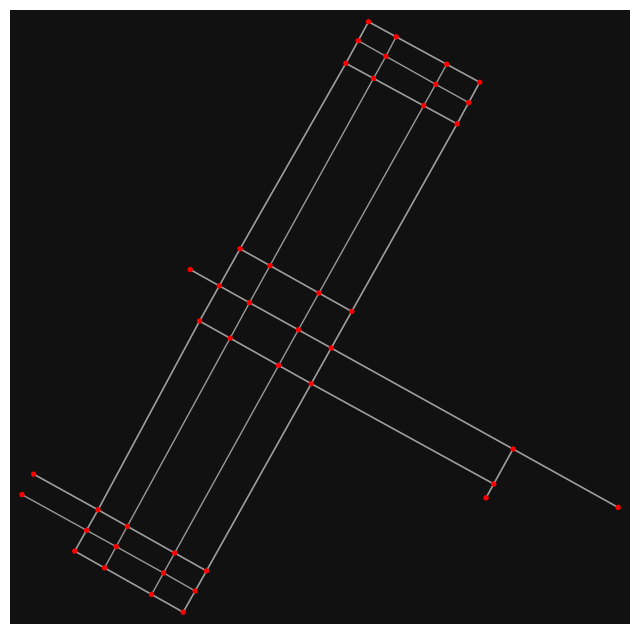

In [65]:
# create a network around some (lat, lng) point but do not simplify it yet
M_location_point = (40.7615775, -73.9706710)
M_G = ox.graph_from_point(M_location_point, network_type="all", dist=100, simplify=False)
fig, ax = ox.plot_graph(M_G, node_color="r")

In [77]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(M_G)
gdf_edges

osmid  oneway lanes              name  \
u           v           key                                               
42432834    10125227996 0      46240204    True     3       Park Avenue   
            596775935   0     497165754   False   NaN  East 57th Street   
            10125227999 0     497165757   False   NaN  East 57th Street   
42443613    10125228003 0     528748997    True     2  East 56th Street   
            10125228000 0     573228989    True     3       Park Avenue   
...                                 ...     ...   ...               ...   
11043182107 8950382042  0     497165757   False   NaN  East 57th Street   
11296256961 8950382042  0     967458619   False   NaN               NaN   
            8835719642  0     967458619   False   NaN               NaN   
            10166509669 0    1219087427   False   NaN               NaN   
11299075975 10168547777 0    1219429414   False   NaN               NaN   

                                 highway maxspeed  reversed  length  \
u           v           key                                           
42432834    10125227996 0        primary   25 mph     False  12.869   
            596775935   0        primary      NaN      True  17.077   
            10125227999 0        primary      NaN     False  11.474   
42443613    10125228003 0    residential      NaN     False  11.109   
            10125228000 0        primary   25 mph     False   6.971   
...                                  ...      ...       ...     ...   
11043182107 8950382042  0        primary      NaN      True  36.713   
11296256961 8950382042  0        service      NaN     False  12.195   
            8835719642  0        service      NaN      True   4.854   
            10166509669 0        footway      NaN     False  63.610   
11299075975 10168547777 0        footway      NaN      True  22.485   

                                                                      geometry  
u           v           key                                                     
42432834    10125227996 0    LINESTRING (-73.97067 40.76158, -73.97060 40.7...  
            596775935   0    LINESTRING (-73.97067 40.76158, -73.97085 40.7...  
            10125227999 0    LINESTRING (-73.97067 40.76158, -73.97055 40.7...  
42443613    10125228003 0    LINESTRING (-73.97116 40.76091, -73.97105 40.7...  
            10125228000 0    LINESTRING (-73.97116 40.76091, -73.97112 40.7...  
...                                                                        ...  
11043182107 8950382042  0    LINESTRING (-73.96951 40.76109, -73.96989 40.7...  
11296256961 8950382042  0    LINESTRING (-73.96996 40.76115, -73.96989 40.7...  
            8835719642  0    LINESTRING (-73.96996 40.76115, -73.96999 40.7...  
            10166509669 0    LINESTRING (-73.96996 40.76115, -73.97062 40.7...  
11299075975 10168547777 0    LINESTRING (-73.97163 40.76118, -73.97140 40.7...  

[111 rows x 9 columns]

In [64]:
print(len(gdf_edges.keys()))
print((gdf_edges.keys()))
print(len(M_G.edges()))

9
Index(['osmid', 'oneway', 'lanes', 'name', 'highway', 'maxspeed', 'reversed',
       'length', 'geometry'],
      dtype='object')
104


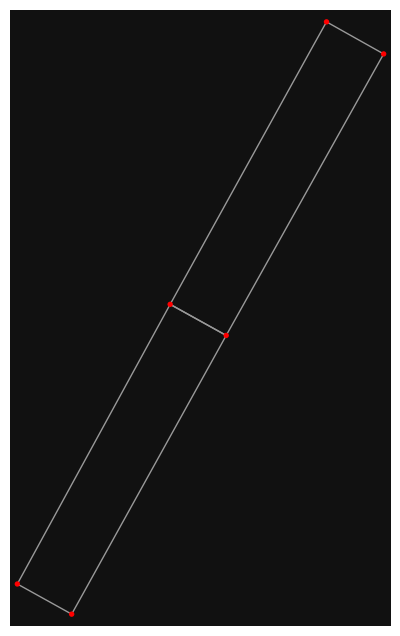

In [66]:
# create a network around some (lat, lng) point but do not simplify it yet
M_location_point = (40.7615775, -73.9706710)
M_G2 = ox.graph_from_point(M_location_point, network_type="drive", dist=100, simplify=True)
fig, ax = ox.plot_graph(M_G2, node_color="r")

In [79]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(M_G2)

print(len(gdf_edges.keys()))
print((gdf_edges.keys()))
print((M_G.nodes()))

9
Index(['osmid', 'name', 'highway', 'oneway', 'reversed', 'length', 'lanes',
       'maxspeed', 'geometry'],
      dtype='object')
[42432834, 42443613, 42456598, 596775935, 596775941, 596775951, 5995346750, 8835719642, 8950382042, 9356012380, 10125156113, 10125156114, 10125227994, 10125227995, 10125227996, 10125227997, 10125227998, 10125227999, 10125228000, 10125228001, 10125228002, 10125228003, 10125228004, 10125228005, 10125228006, 10125228007, 10166509645, 10166509646, 10166509647, 10166509650, 10166509651, 10166509669, 10166509670, 10166509671, 10166509672, 10168547776, 10168547777, 10168547778, 10168547780, 11043182105, 11043182107, 11296256961, 11299075975]


In [83]:

print((len(M_G2.edges())))
gdf_edges

8


osmid              name      highway  oneway  \
u         v         key                                                      
42432834  596775935 0     497165754  East 57th Street      primary   False   
          42456598  0      46240204       Park Avenue      primary    True   
42443613  42432834  0     573228989       Park Avenue      primary    True   
596775935 42432834  0     497165754  East 57th Street      primary   False   
          596775951 0     497165753       Park Avenue      primary    True   
596775941 42456598  0    1115153280  East 58th Street  residential    True   
          596775935 0     671208357       Park Avenue      primary    True   
596775951 42443613  0     528748997  East 56th Street  residential    True   

                         reversed  length lanes maxspeed  \
u         v         key                                    
42432834  596775935 0        True  17.077   NaN      NaN   
          42456598  0       False  85.937     3   25 mph   
42443613  42432834  0       False  84.919     3   25 mph   
596775935 42432834  0       False  17.077   NaN      NaN   
          596775951 0       False  84.913     3   25 mph   
596775941 42456598  0       False  17.464     3   25 mph   
          596775935 0       False  86.026     3   25 mph   
596775951 42443613  0       False  16.560     2      NaN   

                                                                  geometry  
u         v         key                                                     
42432834  596775935 0    LINESTRING (-73.97067 40.76158, -73.97085 40.7...  
          42456598  0    LINESTRING (-73.97067 40.76158, -73.97060 40.7...  
42443613  42432834  0    LINESTRING (-73.97116 40.76091, -73.97112 40.7...  
596775935 42432834  0    LINESTRING (-73.97085 40.76165, -73.97067 40.7...  
          596775951 0    LINESTRING (-73.97085 40.76165, -73.97092 40.7...  
596775941 42456598  0    LINESTRING (-73.97035 40.76233, -73.97017 40.7...  
          596775935 0    LINESTRING (-73.97035 40.76233, -73.97040 40.7...  
596775951 42443613  0    LINESTRING (-73.97133 40.76098, -73.97116 40.7...

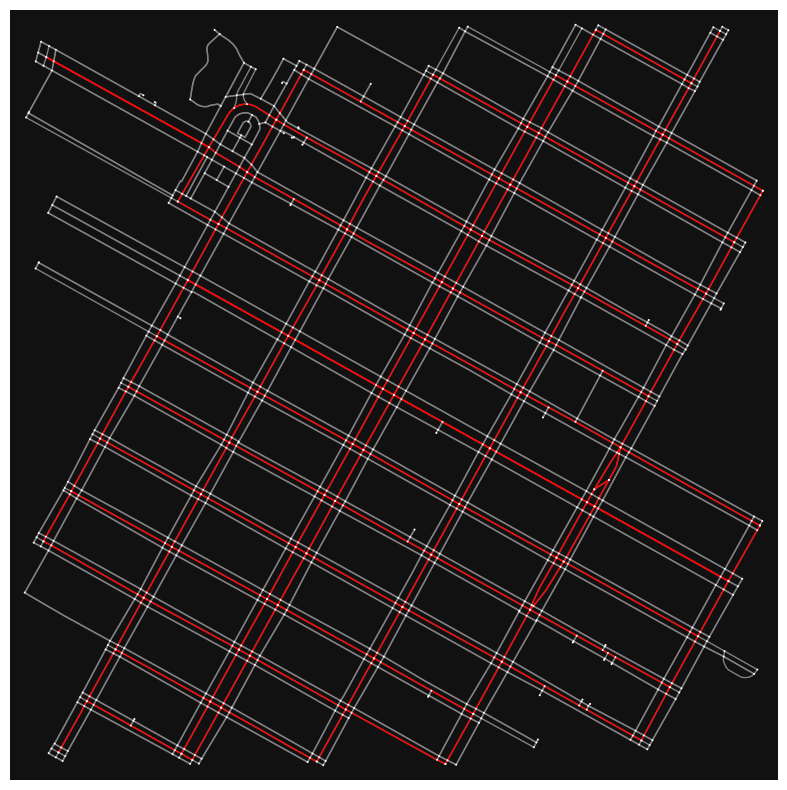

In [140]:
import networkx as nx
M_location_point = (40.7615775, -73.9706710)
# M_location_point = (51.5154297, -0.0933675)
#     network_type : string, {"all_private", "all", "bike", "drive", "drive_service", "walk"}

M_G = ox.graph_from_point(M_location_point, network_type="all", dist=500, simplify=True)

M_G2 = ox.graph_from_point(M_location_point, network_type="drive", dist=500, simplify=True)


M_G3 = nx.disjoint_union(M_G ,M_G2)

# highlight all parallel (multiple) edges
ec1 = ["gray" for i in M_G.edges(keys=True)]
ec2 = ["r" for i in M_G2.edges(keys=True)]
ec = ec1+ec2
fig, ax = ox.plot_graph(
    M_G3,figsize =(10,10), node_color="w", node_size=2, edge_color=ec, edge_linewidth=1
)

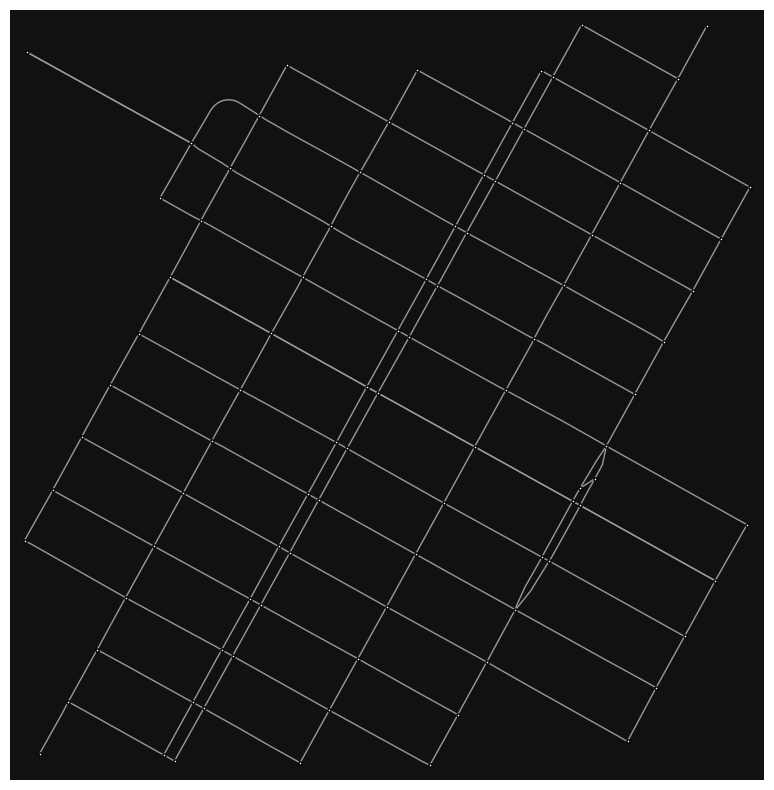

In [141]:
fig, ax = ox.plot_graph(
    M_G2,figsize =(10,10), node_color="w", node_edgecolor="k", node_size=5, edge_linewidth=1
)

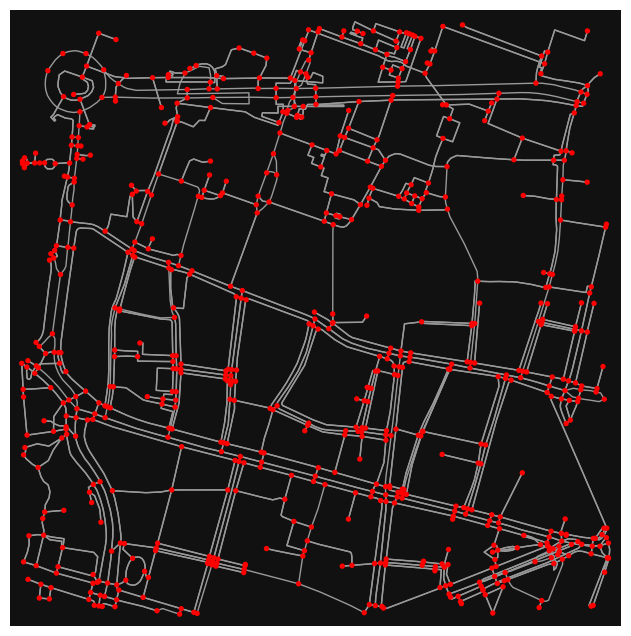

In [45]:
# create a network around some (lat, lng) point but do not simplify it yet
L_location_point = (51.5154297, -0.0933675)
L_G = ox.graph_from_point(L_location_point, network_type="all", dist=300, simplify=True)
fig, ax = ox.plot_graph(L_G, node_color="r")

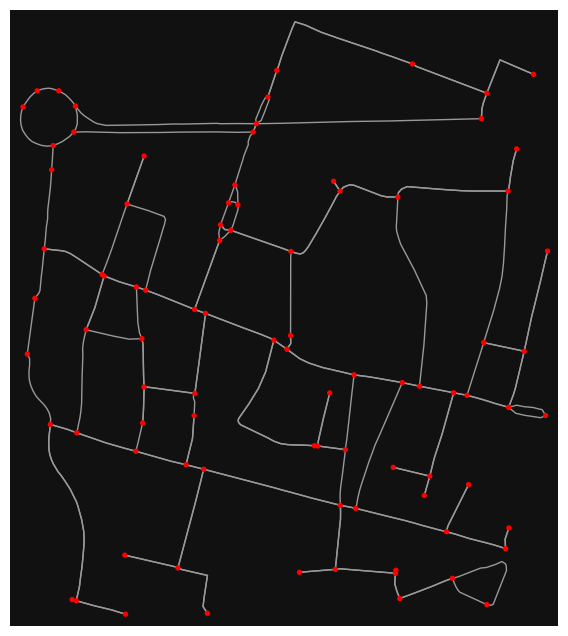

In [37]:
# create a network around some (lat, lng) point but do not simplify it yet
L_location_point = (51.5154297, -0.0933675)
L_G2 = ox.graph_from_point(L_location_point, network_type="drive", dist=300, simplify=True)
fig, ax = ox.plot_graph(L_G2, node_color="r")

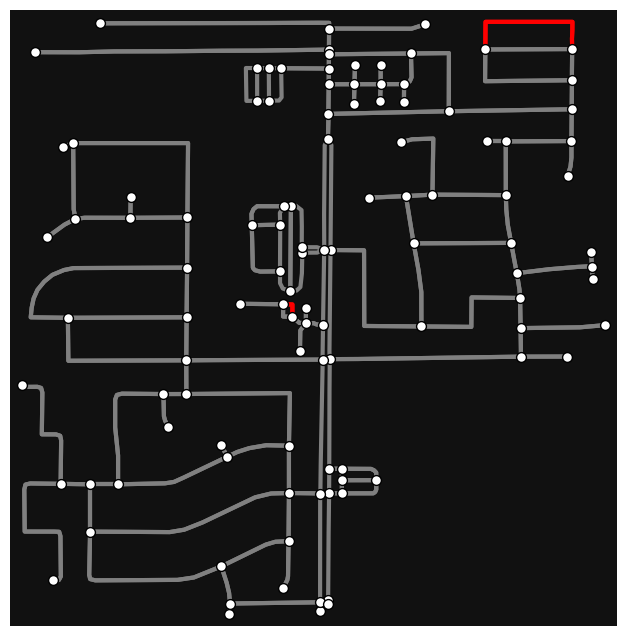

In [60]:
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

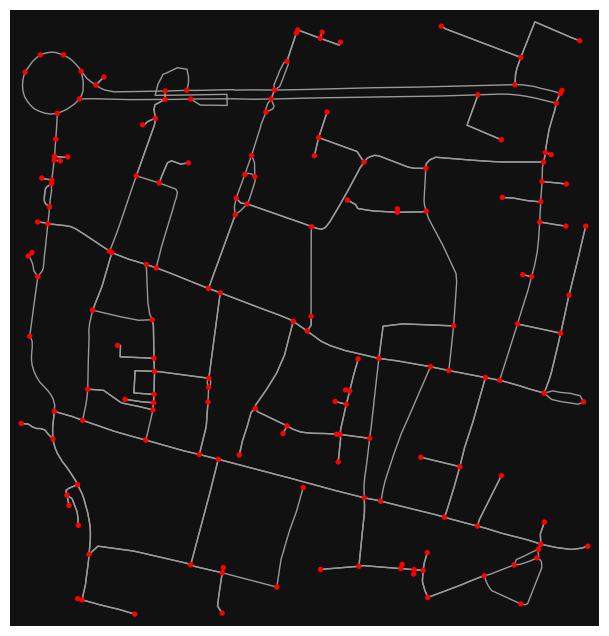

In [38]:
# create a network around some (lat, lng) point but do not simplify it yet
L_location_point = (51.5154297, -0.0933675)
L_G = ox.graph_from_point(L_location_point, network_type="bike", dist=300, simplify=True)
fig, ax = ox.plot_graph(L_G, node_color="r")

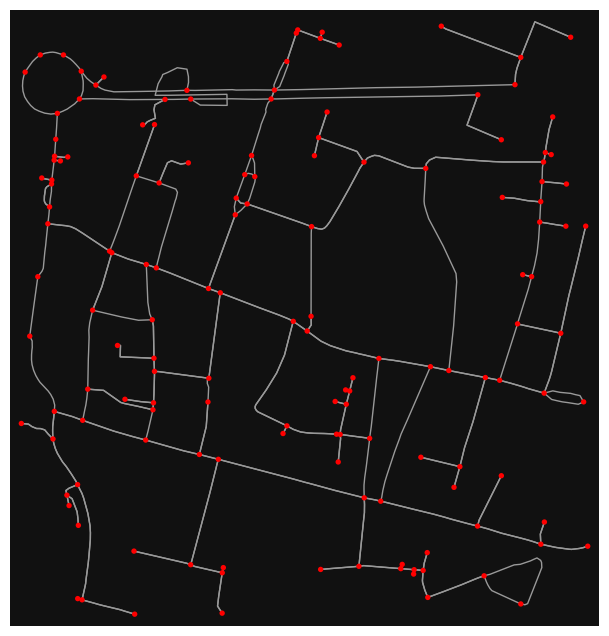

In [39]:
# create a network around some (lat, lng) point but do not simplify it yet
L_location_point = (51.5154297, -0.0933675)
L_G = ox.graph_from_point(L_location_point, network_type="drive_service", dist=300, simplify=True)
fig, ax = ox.plot_graph(L_G, node_color="r")

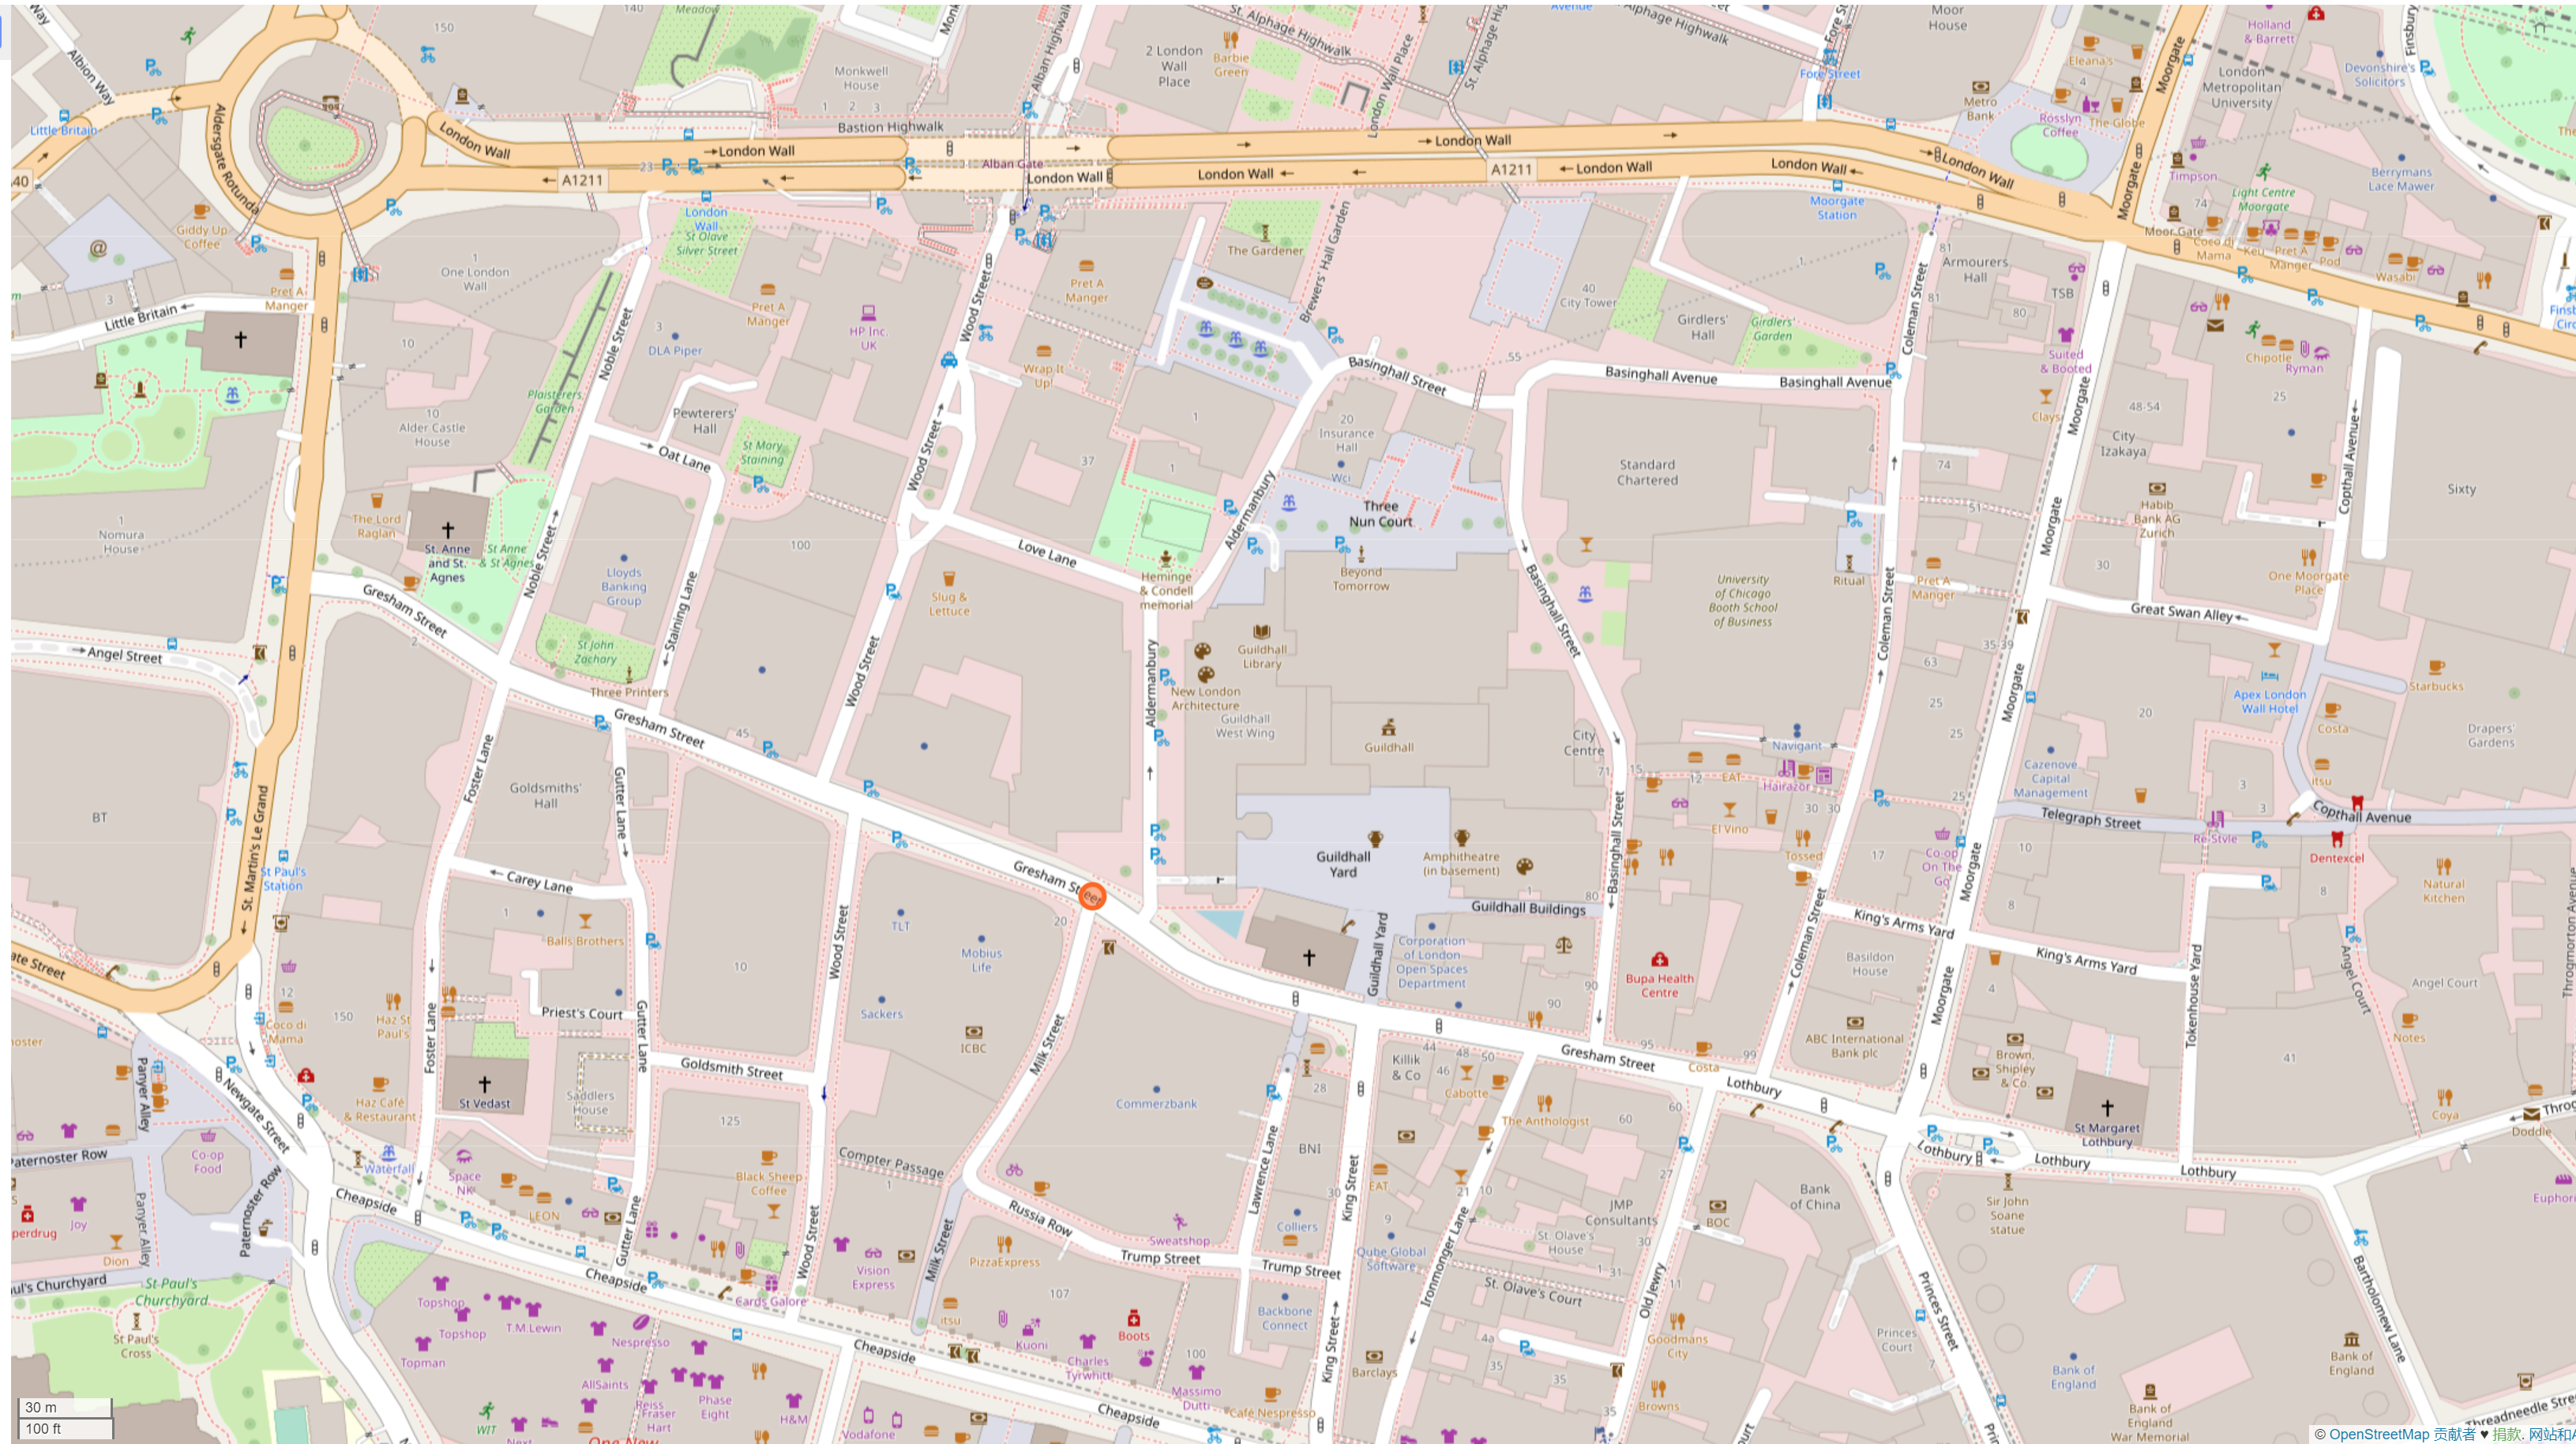

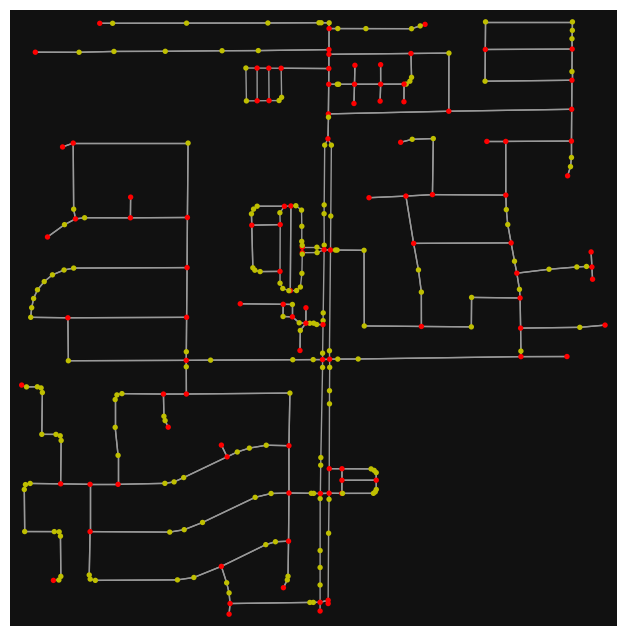

In [20]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(G, node) else "y" for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc)


The dots above are OSM nodes. We'll remove the nodes in yellow as they're not real network nodes (intersections/dead-ends).

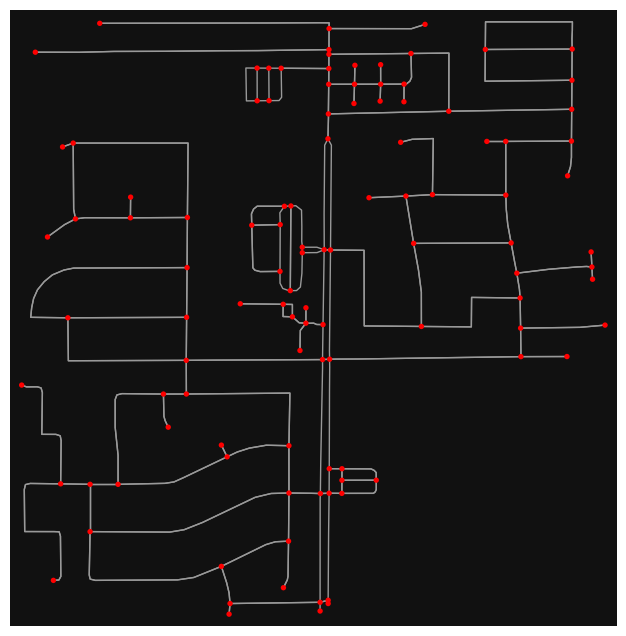

In [21]:
# simplify the network
G = ox.simplify_graph(G)
fig, ax = ox.plot_graph(G, node_color="r")

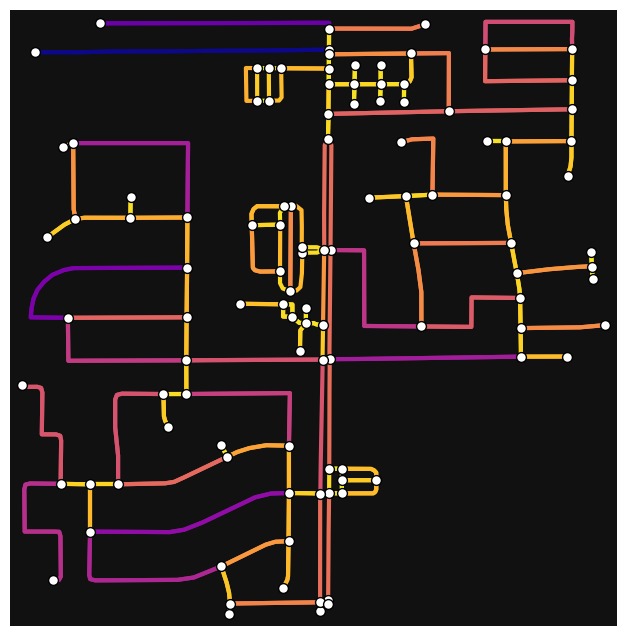

In [92]:
# show the simplified network with edges colored by length
ec = ox.plot.get_edge_colors_by_attr(G, attr="length", cmap="plasma_r")
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [93]:
print(ec)

41542778     41612013     0    (0.994553, 0.728728, 0.171622, 1.0)
             41542784     0    (0.562738, 0.051545, 0.641509, 1.0)
             42449939     0     (0.67916, 0.151848, 0.575189, 1.0)
41542784     42430273     0    (0.994474, 0.722691, 0.174381, 1.0)
             42427959     0    (0.994553, 0.728728, 0.171622, 1.0)
                                              ...                 
10186616217  10186616218  0    (0.968443, 0.894564, 0.147014, 1.0)
10186616218  7153090935   0    (0.977995, 0.861432, 0.142808, 1.0)
             10186616217  0    (0.968443, 0.894564, 0.147014, 1.0)
             41988291     0     (0.990439, 0.796859, 0.14787, 1.0)
10263950589  371860967    0     (0.417642, 0.000564, 0.65839, 1.0)
Length: 252, dtype: object


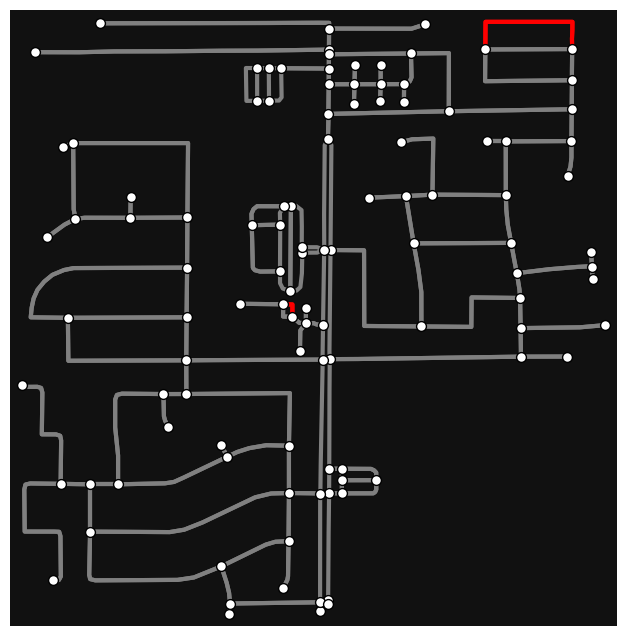

In [94]:
# highlight all parallel (multiple) edges
ec = ["gray" if k == 0 or u == v else "r" for u, v, k in G.edges(keys=True)]
fig, ax = ox.plot_graph(
    G, node_color="w", node_edgecolor="k", node_size=50, edge_color=ec, edge_linewidth=3
)

In [95]:
print(ec)

['gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray', 'gray',

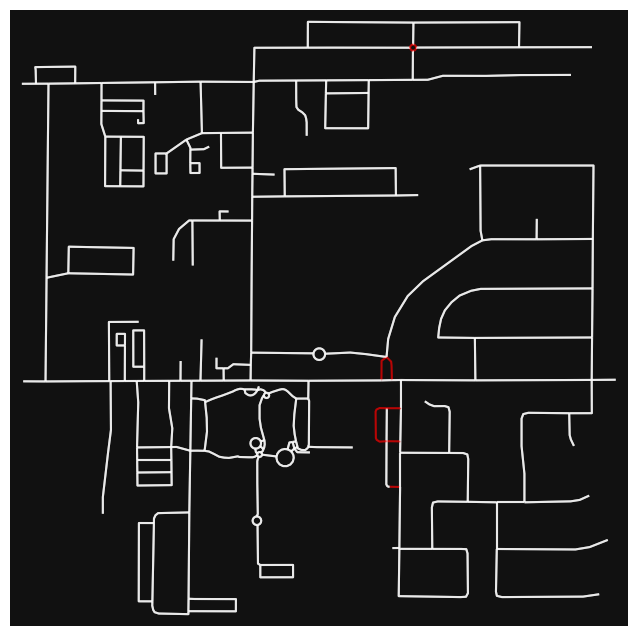

In [14]:
# highlight all one-way edges in the mission district network from earlier
ec = ["r" if data["oneway"] else "w" for u, v, key, data in G.edges(keys=True, data=True)]
fig, ax = ox.plot_graph(G, node_size=0, edge_color=ec, edge_linewidth=1.5, edge_alpha=0.7)

In [17]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

y           x  street_count highway  \
osmid                                                   
41542771  33.296388 -111.830205             3     NaN   
41542772  33.296387 -111.829612             3     NaN   
41542778  33.296386 -111.828450             3     NaN   
41544344  33.303419 -111.832829             4     NaN   
41577408  33.297832 -111.829308             3     NaN   

                             geometry  
osmid                                  
41542771  POINT (-111.83021 33.29639)  
41542772  POINT (-111.82961 33.29639)  
41542778  POINT (-111.82845 33.29639)  
41544344  POINT (-111.83283 33.30342)  
41577408  POINT (-111.82931 33.29783)

In [18]:
gdf_edges.head()

osmid  oneway lanes  \
u        v          key                                                       
41542771 41542772   0                                 5592565   False     2   
                    1    [5671761, 5688100, 5592565, 5656606]   False     2   
         7655352447 0                                 5688100   False     2   
41542772 41542771   0                                 5592565   False     2   
                    1    [5671761, 5688100, 5592565, 5656606]   False     2   

                                                                      name  \
u        v          key                                                      
41542771 41542772   0                                  East Whitten Street   
                    1    [East Glenmere Drive, South Crossbow Drive, So...   
         7655352447 0                                  South Ithica Street   
41542772 41542771   0                                  East Whitten Street   
                    1    [South Ithica Street, East Glenmere Drive, Sou...   

                                         highway maxspeed       reversed  \
u        v          key                                                    
41542771 41542772   0                residential   25 mph          False   
                    1    [tertiary, residential]   25 mph  [False, True]   
         7655352447 0                   tertiary      NaN           True   
41542772 41542771   0                residential   25 mph           True   
                    1    [tertiary, residential]   25 mph  [False, True]   

                          length  \
u        v          key            
41542771 41542772   0     55.114   
                    1    329.650   
         7655352447 0      1.501   
41542772 41542771   0     55.114   
                    1    329.650   

                                                                  geometry  \
u        v          key                                                      
41542771 41542772   0    LINESTRING (-111.83021 33.29639, -111.82961 33...   
                    1    LINESTRING (-111.83021 33.29639, -111.83022 33...   
         7655352447 0    LINESTRING (-111.83021 33.29639, -111.83021 33...   
41542772 41542771   0    LINESTRING (-111.82961 33.29639, -111.83021 33...   
                    1    LINESTRING (-111.82961 33.29639, -111.82909 33...   

                        service access  
u        v          key                 
41542771 41542772   0       NaN    NaN  
                    1       NaN    NaN  
         7655352447 0       NaN    NaN  
41542772 41542771   0       NaN    NaN  
                    1       NaN    NaN

## Part 4: saving networks to disk

For more examples of saving and loading networks to/from disk, see [this notebook](05-save-load-networks.ipynb).

In [ ]:
# save street network as GeoPackage to work with in GIS
ox.save_graph_geopackage(G, filepath="./data/network.gpkg")

In [ ]:
# save street network as GraphML file to work with later in OSMnx or networkx or gephi
ox.save_graphml(G, filepath="./data/network.graphml")

## Part 5: calculate basic network indicators

In [ ]:
# calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G)
stats["circuity_avg"]

In this street network, the streets are ~16% more circuitous than the straight-lines paths would be.

For examples of analyzing street networks, see [this example](06-stats-indicators-centrality.ipynb).